In [1]:
import PIL.Image as im

In [2]:
import numpy as np

In [5]:
flname = 'imageToSave.png'
x = im.open(flname)

In [6]:
x.size

(250, 304)

In [128]:
(np.asarray(x.size) *.25) *5

array([ 596.25,  736.25])

In [131]:
np.asarray(x.size) * .20

array([  95.4,  117.8])

In [132]:
tmp = np.min(np.asarray(x.getdata()), axis=-1).reshape(list(x.size)[::-1] )

In [133]:
np.asarray(x.getdata()).shape

(280953L, 4L)

In [134]:
tmp.shape

(589L, 477L)

In [135]:
tmp2 = np.min(tmp, axis=0)
tmp2.shape

(477L,)

In [136]:
from IPython.display import display, Image

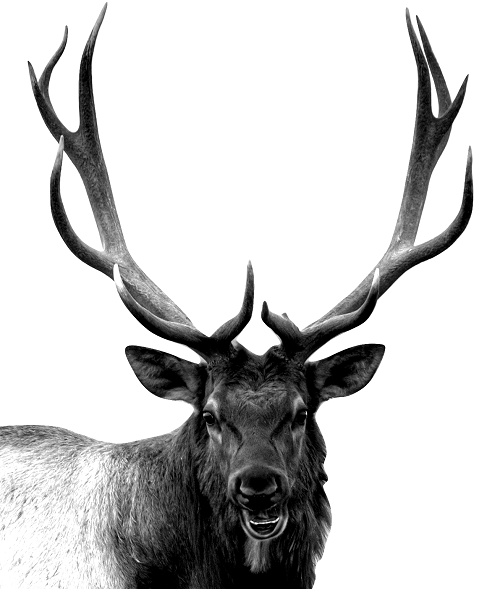

In [137]:
Image(flname)

In [138]:
tmp2 = tmp.astype('float64')
print tmp2
tmp2 = 255. - tmp2 # reverse goddamn colors
tmp2 /= 255.
tmp2 *= 8200-5800
tmp2 += 5800
tmp2

[[ 255.  255.  255. ...,  255.  255.  255.]
 [ 255.  255.  255. ...,  255.  255.  255.]
 [ 255.  255.  255. ...,  255.  255.  255.]
 ..., 
 [ 241.  255.  253. ...,  255.  255.  255.]
 [ 240.  255.  255. ...,  255.  255.  255.]
 [ 249.  255.  255. ...,  255.  255.  255.]]


array([[ 5800.        ,  5800.        ,  5800.        , ...,
         5800.        ,  5800.        ,  5800.        ],
       [ 5800.        ,  5800.        ,  5800.        , ...,
         5800.        ,  5800.        ,  5800.        ],
       [ 5800.        ,  5800.        ,  5800.        , ...,
         5800.        ,  5800.        ,  5800.        ],
       ..., 
       [ 5931.76470588,  5800.        ,  5818.82352941, ...,
         5800.        ,  5800.        ,  5800.        ],
       [ 5941.17647059,  5800.        ,  5800.        , ...,
         5800.        ,  5800.        ,  5800.        ],
       [ 5856.47058824,  5800.        ,  5800.        , ...,
         5800.        ,  5800.        ,  5800.        ]])

In [139]:
def applyWeights(x):
    #x = int(x)
    
    return 7.0448*x*x*x*x*x - 17.159*x*x*x*x + 16.883*x*x*x - 8.1055*x*x + 2.3173*x + 0.0057 # 125% focus, 500mm/m, .50A [.05-.9][2000-12000]
    

vfunc = np.vectorize(applyWeights)

In [161]:
tmp2 = tmp.astype('float64')
print tmp2
tmp2 = 255. - tmp2 # reverse goddamn colors
tmp2 /= 255.
tmp2 = vfunc(tmp2) # apply a nonlienar weight function to spread out the grays
tmp2 *= 3550
tmp2 += 4450
tmp2

[[ 255.  255.  255. ...,  255.  255.  255.]
 [ 255.  255.  255. ...,  255.  255.  255.]
 [ 255.  255.  255. ...,  255.  255.  255.]
 ..., 
 [ 241.  255.  253. ...,  255.  255.  255.]
 [ 240.  255.  255. ...,  255.  255.  255.]
 [ 249.  255.  255. ...,  255.  255.  255.]]


array([[ 4470.235     ,  4470.235     ,  4470.235     , ...,
         4470.235     ,  4470.235     ,  4470.235     ],
       [ 4470.235     ,  4470.235     ,  4470.235     , ...,
         4470.235     ,  4470.235     ,  4470.235     ],
       [ 4470.235     ,  4470.235     ,  4470.235     , ...,
         4470.235     ,  4470.235     ,  4470.235     ],
       ..., 
       [ 4844.52584406,  4470.235     ,  4533.0145296 , ...,
         4470.235     ,  4470.235     ,  4470.235     ],
       [ 4866.06341309,  4470.235     ,  4470.235     , ...,
         4470.235     ,  4470.235     ,  4470.235     ],
       [ 4648.62943105,  4470.235     ,  4470.235     , ...,
         4470.235     ,  4470.235     ,  4470.235     ]])

In [162]:
vfunc(np.asarray([0,10,20,30,40,50,60,70,80,90,100,255])/255.) * 3550 + 4450

array([ 4470.235     ,  4752.06086034,  4965.12388992,  5126.27312131,
        5249.45670039,  5346.00022745,  5424.8850983 ,  5493.02684542,
        5555.55347905,  5616.08382832,  5677.00588234,  7951.365     ])

In [163]:
np.min(tmp), np.max(tmp), np.min(tmp2), np.max(tmp2), np.mean(tmp2)

(0, 255, 4470.2349999999997, 7951.3650000000052, 5090.6141138139583)

In [164]:
tmp2.shape

(589L, 477L)

In [169]:
x = 0
y = 0
step = .2
direction = 1
overrun = 6.
#laserClear = 3000

gcode = 'G21\nG0 X%.1f\nS2000\nM3\nG1 X%.1f\n' % (-overrun, x) # get to x=0

for i, row in enumerate(tmp2[::-1][400:]): # differnet origin (now bottom left)
    for col in row[::direction]:
        
        x += step
        gcode += 'S%.0f\nG1 X%.2f\n' % (col, x) #set intensity, clear pixel
        
    
    if i % 2 == 0:
        
        x += overrun
        gcode += 'S%.0f\nG1 X%.2f\n' % (2000, x) # finished line; clear laser keep moving
        
        y += abs(step)
        x -= overrun
        gcode += 'G1 Y%.2f\nG1 X%.2f\n' % (y, x)
        step *= -1
        direction *= -1 #reverse direction
    else:
        
        x -= overrun
        gcode += 'S%.0f\nG1 X%.2f\n' % (2000, x) # finished line; clear laser keep moving
        y += abs(step)
        x += overrun
        gcode += 'G1 Y%.2f\nG1 X%.2f\n' % (y, x)
        step *= -1
        direction *= -1 #reverse direction
gcode += 'M5'

In [170]:
with open('elk3.gcode', 'w') as fo:
    fo.write(gcode)

In [145]:
#print gcode

In [147]:
tmp2.shape


(589L, 477L)

In [172]:
22./(1*60+37) * ( 4*60 + 40)

63.50515463917526

In [104]:
6500 - 3600

2900

In [106]:
16*5

80

In [101]:
test1 = np.ones((int(5.0/.25), int(5.0/.25))) * 1
test2 = np.ones((int(5.0/.25), int(5.0/.25))) * 2
test3 = np.ones((int(5.0/.25), int(5.0/.25))) * 3
test4 = np.ones((int(5.0/.25), int(5.0/.25))) * 4
test5 = np.ones((int(5.0/.25), int(5.0/.25))) * 5
test6 = np.ones((int(5.0/.25), int(5.0/.25))) * 6
test7 = np.ones((int(5.0/.25), int(5.0/.25))) * 7
test8 = np.ones((int(5.0/.25), int(5.0/.25))) * 8
test9 = np.ones((int(5.0/.25), int(5.0/.25))) * 9
test10 = np.ones((int(5.0/.25), int(5.0/.25))) * 10

test = np.hstack((test1, test2, test3, test4, test5, test6, test7, test8, test9, test10))
test -= 1.0
test *= 150
test += 6200
print test[0][::10]

[ 6200.  6200.  6350.  6350.  6500.  6500.  6650.  6650.  6800.  6800.
  6950.  6950.  7100.  7100.  7250.  7250.  7400.  7400.  7550.  7550.]


In [40]:
height = 3.0
targetW = 116.0
xStepp = 4.0
pixel = .2
xdist = int(xStepp / pixel)
numberOfSteps = int(targetW / xStepp)

tmp = np.ones((int(height/pixel), xdist)) * 1

for i in range(2, numberOfSteps+1):
    tmp2 = np.ones((int(height/pixel), xdist)) * i
    tmp = np.hstack((tmp, tmp2))

test = tmp
test -= 1.0
test *= 75
test += 4000
print test[0][::xdist]
print test.shape, np.asarray(test.shape) * pixel

[ 4000.  4075.  4150.  4225.  4300.  4375.  4450.  4525.  4600.  4675.
  4750.  4825.  4900.  4975.  5050.  5125.  5200.  5275.  5350.  5425.
  5500.  5575.  5650.  5725.  5800.  5875.  5950.  6025.  6100.]
(15L, 580L) [   3.  116.]


In [ ]:
# [ 5500.  5600.  5700.  5800.  5900.  6000.  6100.  6200.  6300.  6400.
#  6500.  6600.  6700.  6800.  6900.  7000.  7100.  7200.  7300.  7400.
#  7500.  7600.  7700.  7800.  7900.  8000.  8100.  8200.  8300.]

[ 4000.  4075.  4150.  4225.  4300.  4375.  4450.  4525.  4600.  4675.
  4750.  4825.  4900.  4975.  5050.  5125.  5200.  5275.  5350.  5425.
  5500.  5575.  5650.  5725.  5800.  5875.  5950.  6025.  6100.]

In [33]:
doMarks = False
if doMarks:
    x = 0
    gcode = 'G21\nG0 X-10\nS2000\nM3\nG1 X0\n'
    for i in range(numberOfSteps+1):
        gcode += 'S9000\nG1 X%.2f\nS5000\nG1 X%.2f\n' % (x+.5, x+xStepp)
        x += xStepp
    gcode += 'G1 X%.2f\nS2000\nG0 x0.0\n' % (x + 10.)
    print gcode

In [41]:
x = 0
y = 0
step = pixel
direction = 1
overrun = 6.
#laserClear = 3000

gcode = 'G21\nG0 X%.1f\nS2000\nM3\nG1 X%.1f\n' % (-overrun, x) # get to x=0

for i, row in enumerate(test):
    for col in row[::direction]:
        
        x += step
        gcode += 'S%.0f\nG1 X%.2f\n' % (col, x) #set intensity, clear pixel
        
    
    if i % 2 == 0:
        
        x += overrun
        gcode += 'S%.0f\nG1 X%.2f\n' % (2000, x) # finished line; clear laser keep moving
        
        y += abs(step)
        x -= overrun
        gcode += 'G1 Y%.2f\nG1 X%.2f\n' % (y, x)
        step *= -1
        direction *= -1 #reverse direction
    else:
        
        x -= overrun
        gcode += 'S%.0f\nG1 X%.2f\n' % (2000, x) # finished line; clear laser keep moving
        y += abs(step)
        x += overrun
        gcode += 'G1 Y%.2f\nG1 X%.2f\n' % (y, x)
        step *= -1
        direction *= -1 #reverse direction
gcode += 'M5'

In [42]:
print gcode

G21
G0 X-6.0
S2000
M3
G1 X0.0
S4000
G1 X0.20
S4000
G1 X0.40
S4000
G1 X0.60
S4000
G1 X0.80
S4000
G1 X1.00
S4000
G1 X1.20
S4000
G1 X1.40
S4000
G1 X1.60
S4000
G1 X1.80
S4000
G1 X2.00
S4000
G1 X2.20
S4000
G1 X2.40
S4000
G1 X2.60
S4000
G1 X2.80
S4000
G1 X3.00
S4000
G1 X3.20
S4000
G1 X3.40
S4000
G1 X3.60
S4000
G1 X3.80
S4000
G1 X4.00
S4075
G1 X4.20
S4075
G1 X4.40
S4075
G1 X4.60
S4075
G1 X4.80
S4075
G1 X5.00
S4075
G1 X5.20
S4075
G1 X5.40
S4075
G1 X5.60
S4075
G1 X5.80
S4075
G1 X6.00
S4075
G1 X6.20
S4075
G1 X6.40
S4075
G1 X6.60
S4075
G1 X6.80
S4075
G1 X7.00
S4075
G1 X7.20
S4075
G1 X7.40
S4075
G1 X7.60
S4075
G1 X7.80
S4075
G1 X8.00
S4150
G1 X8.20
S4150
G1 X8.40
S4150
G1 X8.60
S4150
G1 X8.80
S4150
G1 X9.00
S4150
G1 X9.20
S4150
G1 X9.40
S4150
G1 X9.60
S4150
G1 X9.80
S4150
G1 X10.00
S4150
G1 X10.20
S4150
G1 X10.40
S4150
G1 X10.60
S4150
G1 X10.80
S4150
G1 X11.00
S4150
G1 X11.20
S4150
G1 X11.40
S4150
G1 X11.60
S4150
G1 X11.80
S4150
G1 X12.00
S4225
G1 X12.20
S4225
G1 X12.40
S4225
G1 X12.60
S4225
G1 X1